In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '30'

In [7]:
import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest as SkForest
from coniferest.isoforest import IsolationForest, IsolationForestAnomalyDetector
from coniferest.aadforest import AADForest, AADForestAnomalyDetector
from coniferest.pineforest import PineForest, PineForestAnomalyDetector, ConiferestEvaluator
from coniferest.datasets import MalanchevDataset, Dataset
from coniferest.datasets import Label
from coniferest.experiment import AnomalyDetectionExperiment
import matplotlib.pyplot as plt


import sklearn.decomposition

import gzip

In [8]:
class WeatherData(Dataset):
    "Weather dataset"
    def __init__(self):
        with gzip.open('../datasets/weather/NEweather_data.csv.gz', 'rt') as file:
            self.data = np.genfromtxt(file, delimiter=',')

        with gzip.open('../datasets/weather/NEweather_class.csv.gz', 'rt') as file:
            labels = np.genfromtxt(file, delimiter=',')
            labels[labels == 2] = -1
            self.labels = labels

In [9]:
class ELAsTiCC(Dataset):
    "ELAsTiCC dataset"
    def __init__(self, anomaly_classes=None, regular_classes=None, transformed=True, downsample_ratio=1.0):
        dir = '../datasets/ELAsTiCC/'
        filename = 'features_transf.npy' if transformed else 'features.npy'
        self.data = np.load(dir + filename)
        self.ids = np.load(dir + 'ids.npy')
        self.types = np.load(dir + 'types.npy')

        labels = np.full_like(self.types, Label.R, dtype=Label)
        for klass in anomaly_classes:
            labels[self.types == klass] = Label.A

        self.labels = labels

        if regular_classes is not None:
            index = np.full(labels.shape, False)
            for klass in regular_classes:
                index |= (self.types == klass)
        else:
            index = np.full(labels.shape, True)

        # In case we'd like to downsample
        if downsample_ratio != 1.0:
            anomalies, = np.where(labels == Label.A)
            pivot = np.int(downsample_ratio * len(anomalies))
            index[anomalies[pivot:]] = False
            index[anomalies[:pivot]] = True


        self.labels = self.labels[index]
        self.ids = self.ids[index]
        self.types = self.types[index]
        self.data = self.data[index, :]

In [10]:
class PLAsTiCC(Dataset):
    "PLAsTiCC dataset"
    def __init__(self, anomaly_class='sne'):
        "Anomaly_class may be sne, 91bg, microlens, pisn"
        dir = '../datasets/PLAsTiCC/'
        data_df = pd.read_csv(dir + 'cut_extrapol_-20.0_100.0_g,r,i.csv')
        labels_df = pd.read_csv(dir + f'answers_{anomaly_class}.csv')

        lc_data = data_df.loc[:, 'g-20':'i+100'].to_numpy()
        lc_data_norm = np.amax(lc_data, axis=1).reshape(-1, 1)
        theta_data = data_df.loc[:, 'log_likehood':'theta_8'].to_numpy()
        theta_data_norm = np.amax(theta_data, axis=0) - np.amin(theta_data, axis=0)
        theta_data = theta_data / theta_data_norm
        data = np.hstack([lc_data / lc_data_norm, -2.5 * np.log10(lc_data_norm), theta_data])

        labels = labels_df['is_anomaly'].to_numpy()
        labels[labels == 1] = Label.A
        labels[labels == 0] = Label.R

        super(PLAsTiCC, self).__init__(data.copy(order='C'), labels)
        self.ids = data_df['object_id'].to_numpy()

In [11]:
class GalaxyZoo2(Dataset):
    "Galaxy Zoo 2 dataset"
    def __init__(self):
        path = '../datasets/gz2/astronomaly.parquet'
        tbl = pd.read_parquet(path)
        print(tbl.columns)
        self.data = tbl.drop(columns=['GalaxyID', 'anomaly']).to_numpy().copy(order='C')
    
        anomaly = tbl['anomaly'].to_numpy()
        labels = np.full(anomaly.shape, Label.R)
        labels[anomaly] = Label.A
        self.labels = labels
        
        self.ids = tbl['GalaxyID'].to_numpy()

In [18]:
class CompareThem:
    def __init__(self, dataset, pca=None, capacity=300, options={}):
        self.dataset = dataset
        
        if pca is not None:
            pca_algo = sklearn.decomposition.PCA(n_components=pca)
            data = pca_algo.fit_transform(dataset.data)
        else:
            data = dataset.data
        
        isoforest = IsolationForest(**options.get('isoforest', {}))
        isoforest_det = IsolationForestAnomalyDetector(isoforest)
        self.isoforest_exp = AnomalyDetectionExperiment(isoforest_det, data, dataset.labels, capacity=capacity)
        
        aadforest = AADForest(**options.get('aadforest', {}))
        aadforest_det = AADForestAnomalyDetector(aadforest)
        self.aadforest_exp = AnomalyDetectionExperiment(aadforest_det, data, dataset.labels, capacity=capacity)
    
        pineforest = PineForest(**options.get('pineforest', {}))
        pineforest_det = PineForestAnomalyDetector(pineforest)
        self.pineforest_exp = AnomalyDetectionExperiment(pineforest_det, data, dataset.labels, capacity=capacity)
        
    def run(self, tqdm=False):
        self.isoforest_exp.run(tqdm=tqdm)
        self.aadforest_exp.run(tqdm=tqdm)
        self.pineforest_exp.run(tqdm=tqdm)
    
    def plot(self, title='AD performance curves'):
        plt.figure(figsize=(8, 6))
        plt.title(title)
        
        def performance(exp):
            return np.cumsum(exp.data_labels[exp.trajectory] == Label.A)

        if self.isoforest_exp.trace is not None:
            plt.plot(performance(self.isoforest_exp), label='Isolation Forest')
        
        if self.pineforest_exp.trace is not None:
            plt.plot(performance(self.pineforest_exp), label='Pine Forest')
        
        if self.aadforest_exp.trace is not None:
            plt.plot(performance(self.aadforest_exp), label='AAD Isolation Forest')

        plt.xlabel('number of iteration')
        plt.ylabel('true anomalies detected')
        plt.grid()
        plt.legend()
        pass

CPU times: user 15min 27s, sys: 39.7 s, total: 16min 7s
Wall time: 1min 21s


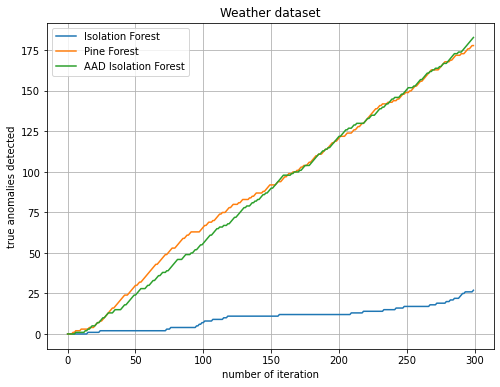

In [19]:
%%time

weather_cmp = CompareThem(WeatherData())
weather_cmp.run()
weather_cmp.plot(title='Weather dataset')

In [67]:
display(pd.DataFrame(np.unique(ELAsTiCC(anomaly_class='dwarf-nova').types, return_counts=True)).T)

,0,1
0,AGN,24992
1,CART,523
2,Cepheid,14169
3,EB,26961
4,ILOT,1848
5,PISN,24077
6,RRL,18576
7,SLSN-I+host,27557
8,SNII+HostXT_V19,3254
9,SNII-NMF,1804


CPU times: user 1h 35min 24s, sys: 3min 25s, total: 1h 38min 49s
Wall time: 6min 21s


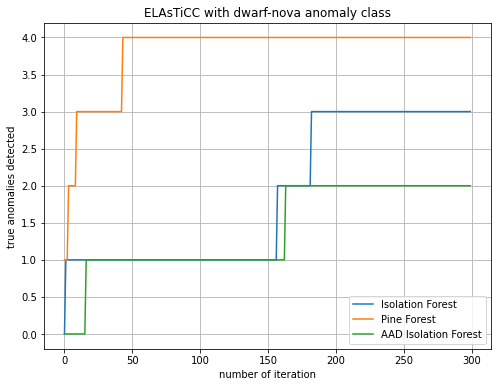

In [20]:
%%time

elasticc_cmp_1 = CompareThem(ELAsTiCC(anomaly_classes=['dwarf-nova']))
elasticc_cmp_1.run()
elasticc_cmp_1.plot(title='ELAsTiCC with dwarf-nova anomaly class')

CPU times: user 2h 19min 37s, sys: 6min 18s, total: 2h 25min 55s
Wall time: 7min 59s


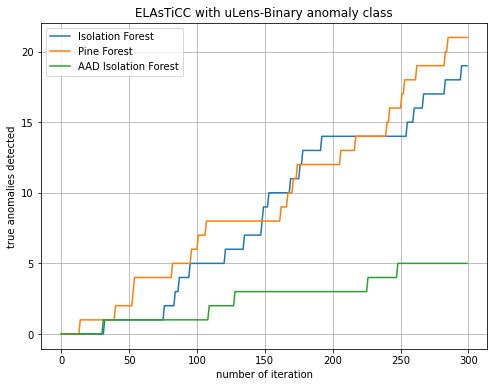

In [21]:
%%time

elasticc_cmp_2 = CompareThem(ELAsTiCC(anomaly_classes=['uLens-Binary']))
elasticc_cmp_2.run()
elasticc_cmp_2.plot(title='ELAsTiCC with uLens-Binary anomaly class')

CPU times: user 8h 5s, sys: 4h 43min 31s, total: 12h 43min 37s
Wall time: 20min 47s


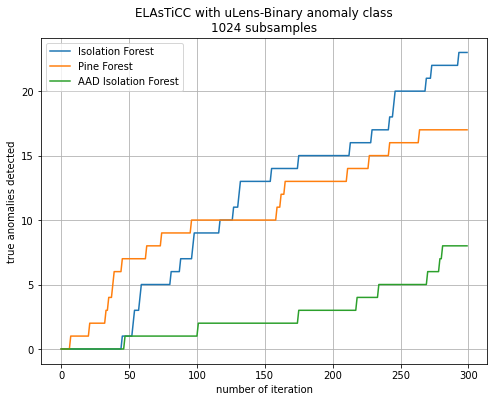

In [24]:
%%time

allopts = { 'n_subsamples': 1024 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_4 = CompareThem(ELAsTiCC(anomaly_classes=['uLens-Binary']), options=options)
elasticc_cmp_4.run()
elasticc_cmp_4.plot(title='ELAsTiCC with uLens-Binary anomaly class\n1024 subsamples')

CPU times: user 11h 19min 38s, sys: 2h 3min 43s, total: 13h 23min 22s
Wall time: 33min 27s


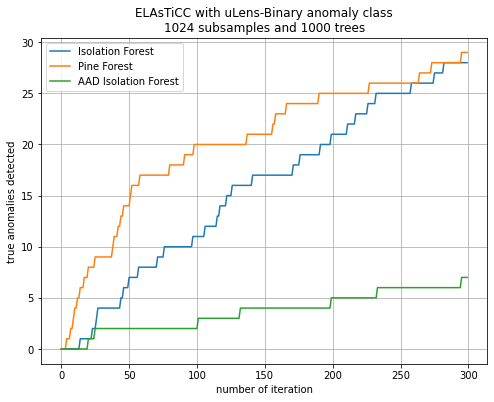

In [25]:
%%time

allopts = { 'n_subsamples': 1024, 'n_trees': 1000 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_5 = CompareThem(ELAsTiCC(anomaly_classes=['uLens-Binary']), options=options)
elasticc_cmp_5.run()
elasticc_cmp_5.plot(title='ELAsTiCC with uLens-Binary anomaly class\n1024 subsamples and 1000 trees')

CPU times: user 10h 51min 44s, sys: 2h 8min 5s, total: 12h 59min 49s
Wall time: 33min 42s


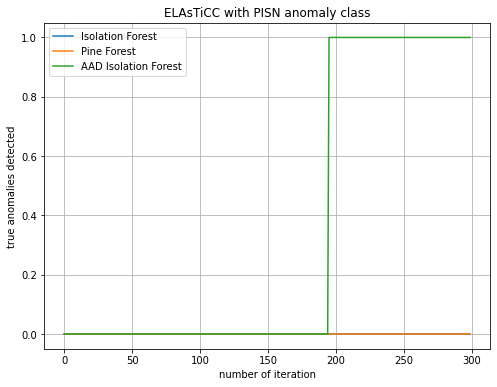

In [26]:
%%time

allopts = { 'n_subsamples': 1024, 'n_trees': 1000 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_6 = CompareThem(ELAsTiCC(anomaly_classes=['PISN'], downsample_ratio=0.02), options=options)
elasticc_cmp_6.run()
elasticc_cmp_6.plot(title='ELAsTiCC with PISN anomaly class')

In [39]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

# 'Cepheid'
elasticc_cmp_7 = CompareThem(ELAsTiCC(regular_classes=['AGN', 'SLSN-I+host'], anomaly_class=['PISN']), downsample_ratio=0.02, options=options)
elasticc_cmp_7.run()
elasticc_cmp_7.plot(title='ELAsTiCC with AGN and SLSN-I+host anomaly class')

TypeError: __init__() got an unexpected keyword argument 'anomaly_class'

CPU times: user 1h 26min 48s, sys: 4min 55s, total: 1h 31min 44s
Wall time: 5min 56s


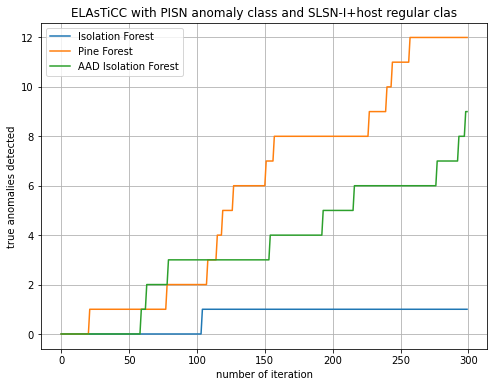

In [28]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_8 = CompareThem(ELAsTiCC(regular_classes=['SLSN-I+host'], anomaly_classes=['PISN'], downsample_ratio=0.02), options=options)
elasticc_cmp_8.run()
elasticc_cmp_8.plot(title='ELAsTiCC with PISN anomaly class and SLSN-I+host regular clas')

CPU times: user 28min 22s, sys: 1min 29s, total: 29min 51s
Wall time: 1min 48s


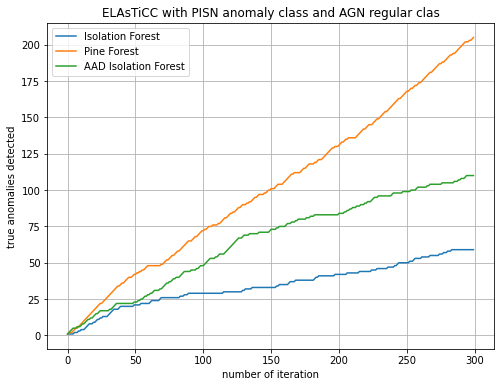

In [29]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_9 = CompareThem(ELAsTiCC(regular_classes=['AGN'], anomaly_classes=['PISN'], downsample_ratio=0.02), options=options)
elasticc_cmp_9.run()
elasticc_cmp_9.plot(title='ELAsTiCC with PISN anomaly class and AGN regular class')

CPU times: user 2h 35min 31s, sys: 7min 8s, total: 2h 42min 39s
Wall time: 8min 51s


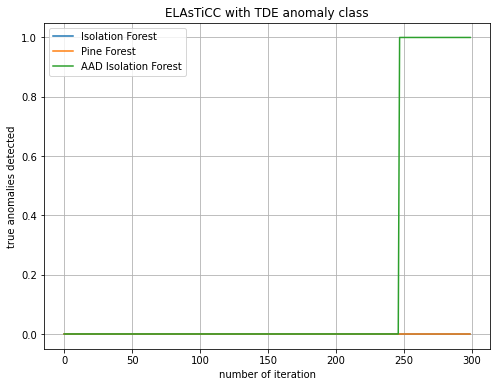

In [30]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }


elasticc_cmp_10 = CompareThem(ELAsTiCC(anomaly_classes=['TDE'], downsample_ratio=0.03), options=options)
elasticc_cmp_10.run()
elasticc_cmp_10.plot(title='ELAsTiCC with TDE anomaly class')

CPU times: user 2h 15min 45s, sys: 6min 11s, total: 2h 21min 57s
Wall time: 8min


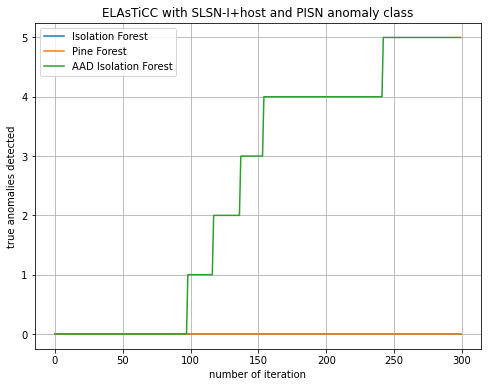

In [31]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }


elasticc_cmp_11 = CompareThem(ELAsTiCC(anomaly_classes=['SLSN-I+host', 'PISN'], downsample_ratio=0.03), options=options)
elasticc_cmp_11.run()
elasticc_cmp_11.plot(title='ELAsTiCC with SLSN-I+host and PISN anomaly class')

Index(['Residual_90', 'Residual_80', 'Residual_70', 'Residual_60',
       'Residual_50', 'Residual_0', 'Offset_90', 'Offset_80', 'Offset_70',
       'Offset_60', 'Offset_50', 'Offset_0', 'Aspect_90', 'Aspect_80',
       'Aspect_70', 'Aspect_60', 'Aspect_50', 'Aspect_0', 'Theta_90',
       'Theta_80', 'Theta_70', 'Theta_60', 'Theta_50', 'Theta_0', 'Maj_90',
       'Maj_80', 'Maj_70', 'Maj_60', 'Maj_50', 'Maj_0', 'GalaxyID', 'anomaly'],
      dtype='object')


100%|██████████| 2000/2000 [18:43<00:00,  1.78it/s]

CPU times: user 18h 57min 6s, sys: 44min 38s, total: 19h 41min 45s
Wall time: 1h 1min 11s


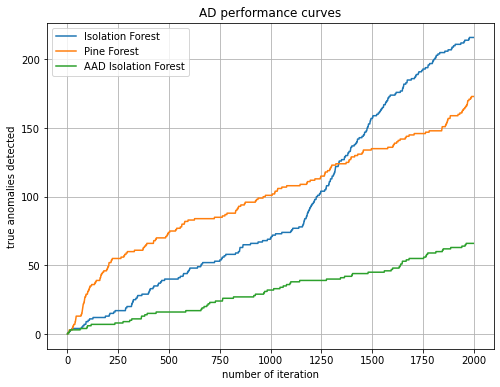

In [42]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }


gz_24 = CompareThem(GalaxyZoo2(), options=options, capacity=2000)
gz_24.run(tqdm=True)
gz_24.plot()

Index(['Residual_90', 'Residual_80', 'Residual_70', 'Residual_60',
       'Residual_50', 'Residual_0', 'Offset_90', 'Offset_80', 'Offset_70',
       'Offset_60', 'Offset_50', 'Offset_0', 'Aspect_90', 'Aspect_80',
       'Aspect_70', 'Aspect_60', 'Aspect_50', 'Aspect_0', 'Theta_90',
       'Theta_80', 'Theta_70', 'Theta_60', 'Theta_50', 'Theta_0', 'Maj_90',
       'Maj_80', 'Maj_70', 'Maj_60', 'Maj_50', 'Maj_0', 'GalaxyID', 'anomaly'],
      dtype='object')


100%|██████████| 2000/2000 [38:44<00:00,  1.16s/it]

CPU times: user 19h 6s, sys: 40min 21s, total: 19h 40min 27s
Wall time: 1h 20min 1s


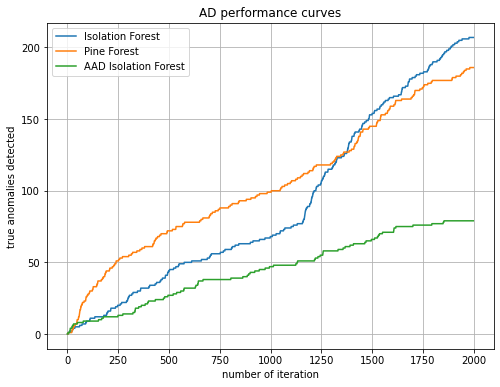

In [41]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
pineopts = allopts.copy()
pineopts['n_spare_trees'] = 900
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': pineopts }


gz_21 = CompareThem(GalaxyZoo2(), capacity=2000, options=options)
gz_21.run(tqdm=True)
gz_21.plot()

Index(['Residual_90', 'Residual_80', 'Residual_70', 'Residual_60',
       'Residual_50', 'Residual_0', 'Offset_90', 'Offset_80', 'Offset_70',
       'Offset_60', 'Offset_50', 'Offset_0', 'Aspect_90', 'Aspect_80',
       'Aspect_70', 'Aspect_60', 'Aspect_50', 'Aspect_0', 'Theta_90',
       'Theta_80', 'Theta_70', 'Theta_60', 'Theta_50', 'Theta_0', 'Maj_90',
       'Maj_80', 'Maj_70', 'Maj_60', 'Maj_50', 'Maj_0', 'GalaxyID', 'anomaly'],
      dtype='object')


100%|██████████| 2000/2000 [40:39<00:00,  1.22s/it]

CPU times: user 2d 21h 24min 19s, sys: 1d 17h 18min 50s, total: 4d 14h 43min 9s
Wall time: 2h 38min 30s


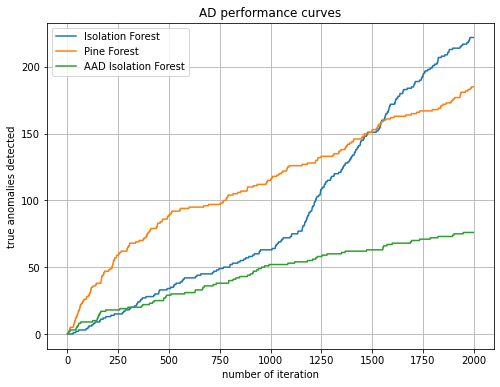

In [43]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 300 }
pineopts = allopts.copy()
pineopts['n_spare_trees'] = 900
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': pineopts }


gz_22 = CompareThem(GalaxyZoo2(), capacity=2000, options=options)
gz_22.run(tqdm=True)
gz_22.plot()

Index(['Residual_90', 'Residual_80', 'Residual_70', 'Residual_60',
       'Residual_50', 'Residual_0', 'Offset_90', 'Offset_80', 'Offset_70',
       'Offset_60', 'Offset_50', 'Offset_0', 'Aspect_90', 'Aspect_80',
       'Aspect_70', 'Aspect_60', 'Aspect_50', 'Aspect_0', 'Theta_90',
       'Theta_80', 'Theta_70', 'Theta_60', 'Theta_50', 'Theta_0', 'Maj_90',
       'Maj_80', 'Maj_70', 'Maj_60', 'Maj_50', 'Maj_0', 'GalaxyID', 'anomaly'],
      dtype='object')


100%|██████████| 2000/2000 [1:05:16<00:00,  1.96s/it]

CPU times: user 34d 23h 30min 2s, sys: 19d 7h 54min 32s, total: 54d 7h 24min 35s
Wall time: 23h 49min 8s


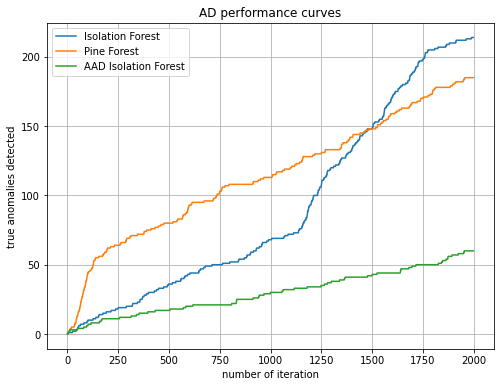

In [33]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 3000 }
pineopts = allopts.copy()
pineopts['n_spare_trees'] = 900
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': pineopts }


gz_20 = CompareThem(GalaxyZoo2(), capacity=2000, options=options)
gz_20.run(tqdm=True)
gz_20.plot()

Index(['Residual_90', 'Residual_80', 'Residual_70', 'Residual_60',
       'Residual_50', 'Residual_0', 'Offset_90', 'Offset_80', 'Offset_70',
       'Offset_60', 'Offset_50', 'Offset_0', 'Aspect_90', 'Aspect_80',
       'Aspect_70', 'Aspect_60', 'Aspect_50', 'Aspect_0', 'Theta_90',
       'Theta_80', 'Theta_70', 'Theta_60', 'Theta_50', 'Theta_0', 'Maj_90',
       'Maj_80', 'Maj_70', 'Maj_60', 'Maj_50', 'Maj_0', 'GalaxyID', 'anomaly'],
      dtype='object')


100%|██████████| 2000/2000 [38:45<00:00,  1.16s/it]

CPU times: user 14h 38min 19s, sys: 36min 40s, total: 15h 14min 59s
Wall time: 1h 10min 26s


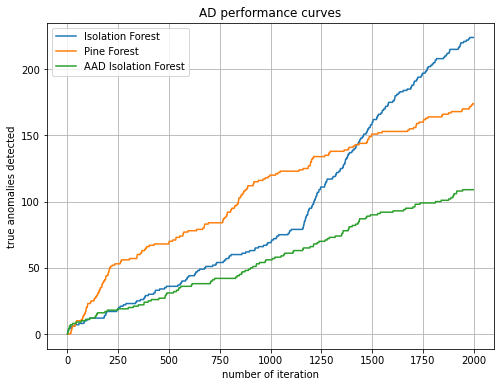

In [44]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
pineopts = allopts.copy()
pineopts['n_spare_trees'] = 900
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': pineopts }


gz_30 = CompareThem(GalaxyZoo2(), capacity=2000, options=options)
gz_30.run(tqdm=True)
gz_30.plot()

Index(['Residual_90', 'Residual_80', 'Residual_70', 'Residual_60',
       'Residual_50', 'Residual_0', 'Offset_90', 'Offset_80', 'Offset_70',
       'Offset_60', 'Offset_50', 'Offset_0', 'Aspect_90', 'Aspect_80',
       'Aspect_70', 'Aspect_60', 'Aspect_50', 'Aspect_0', 'Theta_90',
       'Theta_80', 'Theta_70', 'Theta_60', 'Theta_50', 'Theta_0', 'Maj_90',
       'Maj_80', 'Maj_70', 'Maj_60', 'Maj_50', 'Maj_0', 'GalaxyID', 'anomaly'],
      dtype='object')


100%|██████████| 2000/2000 [41:06<00:00,  1.23s/it]

CPU times: user 3d 6h 56min, sys: 1d 23h 28min 5s, total: 5d 6h 24min 5s
Wall time: 2h 56min 4s


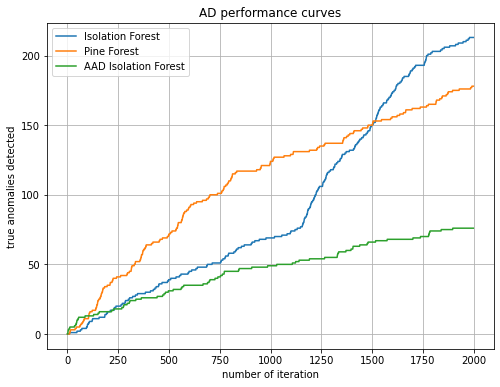

In [45]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 300 }
pineopts = allopts.copy()
pineopts['n_spare_trees'] = 900
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': pineopts }


gz_31 = CompareThem(GalaxyZoo2(), capacity=2000, options=options)
gz_31.run(tqdm=True)
gz_31.plot()

In [185]:
%%time

dataset = GalaxyZoo2()
pineforest = PineForest()
trees = pineforest.trees

for n in [48, 100, 220, 480, 1000, 2200, 10000, 22000]:
    trees.extend(pineforest.build_trees(dataset.data, n - len(trees)))
    pineforest.evaluator = ConiferestEvaluator(pineforest)
    scores = pineforest.evaluator.score_samples(dataset.data)
    print(f'{n:4d}', np.argsort(scores)[:10])

  48 [ 4182 62240  1904 23371 61729 62043 50082 12451 26864 62335]
 100 [ 1904 62240  4182 23371 61729 62335 62043 12451 61643 21109]
 220 [62240 62335 61729  4182 23371  1904 61643 12451 17112 62156]
 480 [62240 62335 61729  4182 12451  1904 17112 61643 23371 62156]
1000 [62240 62335 61729  4182 12451 23371 62156 61643  1904 31897]
2200 [62335 61729 62240  4182 12451 61643 23371 62156  1904 19108]
10000 [61729 62335 62240  4182 12451 23371 61643 62156 31897 19108]
22000 [61729 62335 62240  4182 12451 23371 61643 62156 31897 19108]
CPU times: user 5min 11s, sys: 1.61 s, total: 5min 13s
Wall time: 46 s


In [211]:
t = pc.isoforest_exp.regressor.isoforest.trees[0]

In [40]:
0

0